In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

import PIL
from PIL import Image

In [284]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        # img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [296]:
network = Net(100*100*3, 300, 200, 20)
optimizer = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.6)
criterion = nn.MSELoss()

print(network)

Net(
  (fc1): Linear(in_features=30000, out_features=300, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=200, out_features=20, bias=True)
)


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

Class name: a


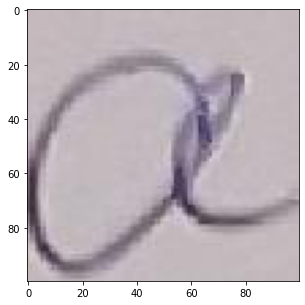

In [289]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
epochs = 10

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [291]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [300]:
def train(train_loader):
  network.eval()
  for data in train_loader:
    images = data['image']
    optimizer.zero_grad()

    print(images[0].shape)

    outputs = network(images.flatten().float())

train(train_loader)

torch.Size([100, 100, 3])


RuntimeError: ignored